In [1]:
import sys
curr_dir = '/user_data/vayzenbe/GitHub_Repos/kornet'

#add curr_dir to path
sys.path.insert(1, curr_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob as glob

In [54]:
data_dir = f'{curr_dir}/data'
results_dir = f'{curr_dir}/results'
fig_dir = f'{curr_dir}/figures'


sub_info = pd.read_csv(f'{data_dir}/sub_info.csv' )
#remove subjects with NaNs in code field
sub_info = sub_info[~sub_info['code'].isna()]
#remove subjects with 1 in exclude field
sub_info = sub_info[sub_info['exclude'] != 1]


benchmark_models = ['vonecornet_s','cornet_s','voneresnet', 'vit','convnext','resnet50','resnext50','alexnet','vgg19', 'ShapeNet','SayCam']

conds = ['complete', 'perturbed','deleted']
model_conds = ['Outline','Pert','IC']
durations = [.3,.25, .2,.15,.1]
speed = ['intro','slow','slow','fast','fast']

age_groups = ['3yrold','4yrold','5yrold']


### Create child summary

In [55]:


sub_summary = pd.DataFrame(columns = ['sub','sex','age','cond','duration','acc','rt'])

for sub in sub_info['sub']:

    sub_cond = sub_info[sub_info['sub']==sub]['cond'].values[0] -1 #subtract 1 because conditions are 1 2 3
    sub_file = glob(f'{data_dir}/{conds[sub_cond]}/{sub}_*.csv')
    #check if subfile is not empty
    if len(sub_file) != 0:
        sub_file = sub_file[0]
    
        temp_summary = pd.DataFrame(columns = sub_summary.columns)
        #glob a file from cond with sub number
        

        #load sub data
        sub_data = pd.read_csv(sub_file)

        #remove practice trials
        sub_data = sub_data[sub_data['pracTrials.ran']!=1]
        acc = sub_data.groupby(['Duration']).mean()
        sem = sub_data.groupby(['Duration']).sem()
        sem = sem.reset_index()
        

        #extract rt data where corr is 1
        rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration']).mean()

        temp_summary['acc'] = acc['resp.corr']
        temp_summary['rt'] = rt['resp.rt']
        temp_summary['duration']= acc.index
        temp_summary['sub'] = sub
        temp_summary['cond'] = conds[sub_cond]
        temp_summary['age'] = sub_info[sub_info['sub']==sub]['age'].values[0]
        temp_summary['age_group'] = np.floor(sub_info[sub_info['sub']==sub]['age'].values[0]).astype(str)[:-2] + 'yrold'
        temp_summary['sex'] = sub_info[sub_info['sub']==sub]['sex'].values[0]
        

        #check if acc for .3 duration is over .5
        #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > (.5+ sem['resp.corr'][sem['Duration'] == .30].values[0]):
        sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)
        


    else:
        print(f'no file for {sub}')


#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]
    
    
#save long format    
sub_summary.to_csv(f'{results_dir}/sub_summary_long.csv', index = False)







no file for 6032
no file for 6096
no file for 6123


In [57]:
'''Convert to wide format'''

sub_summary_wide = sub_summary
#Remove any durations over .35
sub_summary_wide = sub_summary_wide[sub_summary_wide['duration']<=.3]

#calculate sd across all kids
sd = sub_summary_wide['acc'].std() 

#remove old speed colums
sub_summary_wide = sub_summary_wide.drop(columns = ['speed'])

#first convert duration to string
sub_summary_wide['duration'] = sub_summary_wide['duration'].astype(str)
#convert age_group to string
sub_summary_wide['age_group'] = sub_summary_wide['age_group'].astype(str)


#pivot to wide
sub_summary_wide = pd.pivot(sub_summary_wide,index = ['sub','sex','age','age_group','cond'],columns = ['duration'])

#Format cols
sub_summary_wide.columns = list(map("_".join, sub_summary_wide.columns.values))
sub_summary_wide = sub_summary_wide.reset_index()

for duration in durations:
    #replace NaN accs with .5 - SD
    sub_summary_wide[f'acc_{duration}'] = sub_summary_wide[f'acc_{duration}'].fillna(.5 - sd)
    
#create new speed columns
sub_summary_wide['fast'] = sub_summary_wide[['acc_0.1', 'acc_0.15']].mean(axis = 1)
sub_summary_wide['slow'] = sub_summary_wide[['acc_0.2', 'acc_0.25']].mean(axis = 1)


sub_summary_wide.to_csv(f'{results_dir}/sub_summary_wide.csv', index = False)


### Create model summary benchmark

In [58]:

model_summary = pd.DataFrame(columns = ['model','cond','acc','ci_low', 'ci_high'])
#load sub summary
sub_summary = pd.read_csv(f'{results_dir}/sub_summary_wide.csv')

for cond in model_conds:
    
    for model in benchmark_models:
        #load model data
        model_data = pd.read_csv(f'{results_dir}/{model}_{cond}_summary.csv')

        #calculate mean acc 
        acc = model_data['acc'].mean()
        #calculate CIs for acc
        ci_low = acc- model_data['acc'].sem()*1.96
        ci_high = acc+ model_data['acc'].sem()*1.96
        


        #compile data into list
        temp_df = [model, conds[model_conds.index(cond)], acc, ci_low, ci_high]
        #append to model_summary
        temp_summary = pd.DataFrame([temp_df], columns = model_summary.columns)


        model_summary = pd.concat([model_summary, temp_summary], axis = 0)

    for age in age_groups:
        for speed in ['fast', 'slow']:
            #extract sub data for age, cond, and speed
            temp_sub_summary = sub_summary[(sub_summary['age_group']==age) & (sub_summary['cond']==conds[model_conds.index(cond)])]

            #calculate mean acc
            acc = temp_sub_summary[speed].mean()
            #calculate CIs for acc
            ci_low = acc- temp_sub_summary[speed].sem()*1.96
            ci_high = acc+ temp_sub_summary[speed].sem()*1.96

            #compile data into list
            temp_df = [f'{age}_{speed}', conds[model_conds.index(cond)], acc, ci_low, ci_high]
            temp_summary = pd.DataFrame([temp_df], columns = model_summary.columns)
            #append to model_summary
            model_summary = pd.concat([model_summary, temp_summary], axis = 0)


model_summary.to_csv(f'{results_dir}/model_summary.csv', index = False)

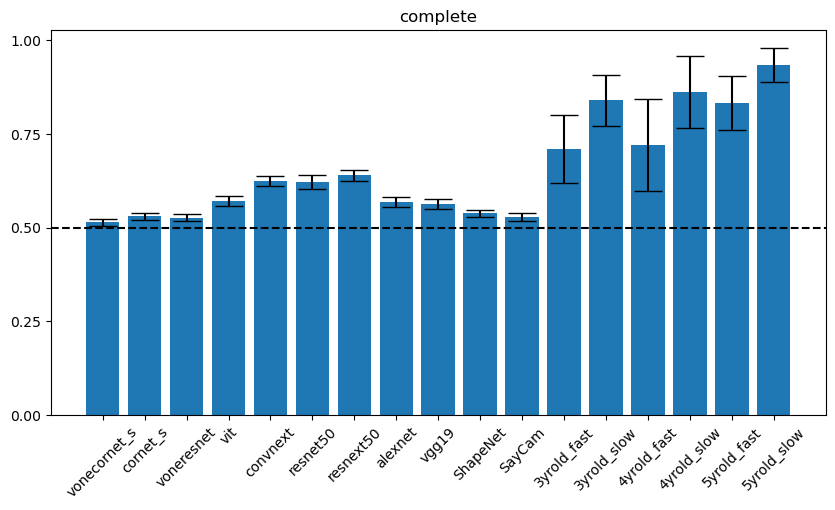

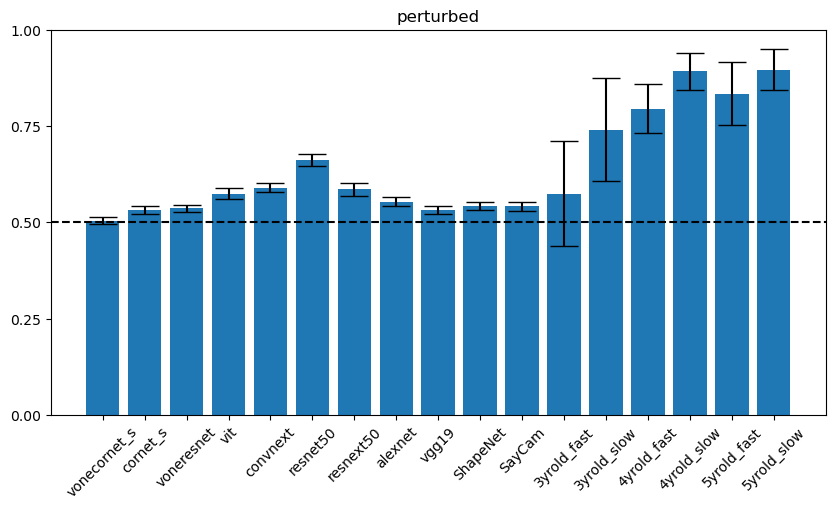

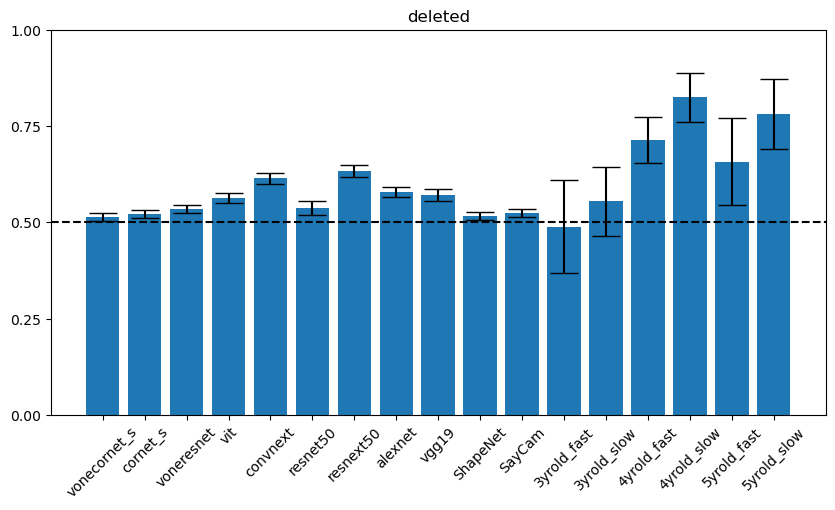

In [59]:
for cond in conds:
    #extract cond from model summary
    temp_model_summary = model_summary[model_summary['cond']==cond]

    #plot bar graph with CIs from model summary
    plt.figure(figsize = (10,5))
    plt.bar(temp_model_summary['model'], temp_model_summary['acc'], yerr = temp_model_summary['ci_high']-temp_model_summary['acc'], capsize = 10)
    #orient x-axis labels 45 degrees
    plt.xticks(rotation=45)

    #add cond as title
    plt.title(cond)

    #add dotted line at .5
    plt.axhline(.5, linestyle = '--', color = 'black')

    #increment y axis by .25
    plt.yticks(np.arange(0, 1.25, .25))


In [27]:
model_summary

,model,cond,acc,ci_low,ci_high
0,vonecornet_s,complete,0.51381,0.503514,0.524105
0,cornet_s,complete,0.530159,0.520472,0.539845
0,voneresnet,complete,0.526508,0.516789,0.536227
0,vit,complete,0.571032,0.557532,0.584532
0,convnext,complete,0.624206,0.610142,0.638271
0,resnet50,complete,0.621984,0.60386,0.640108
0,resnext50,complete,0.639206,0.624053,0.65436
0,alexnet,complete,0.568651,0.556136,0.581166
0,vgg19,complete,0.56254,0.548922,0.576158
0,ShapeNet,complete,0.53754,0.528195,0.546885


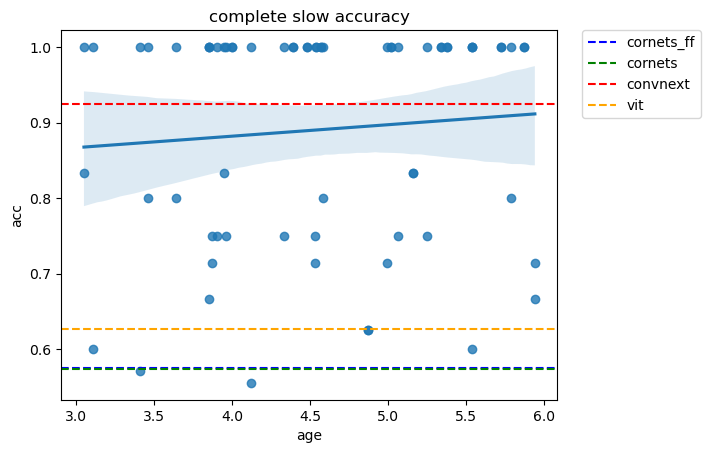

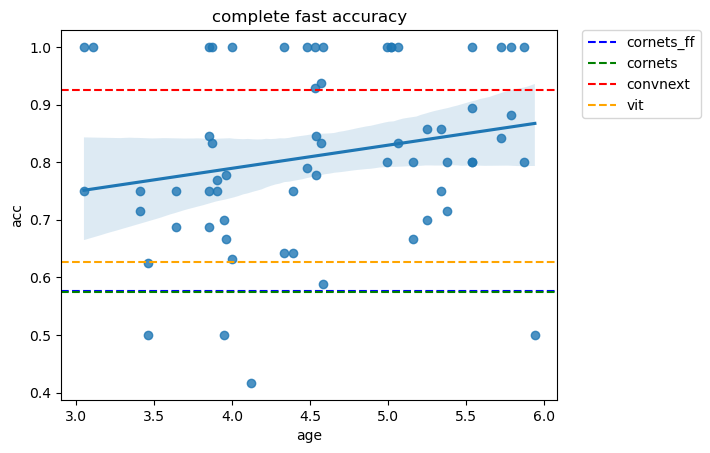

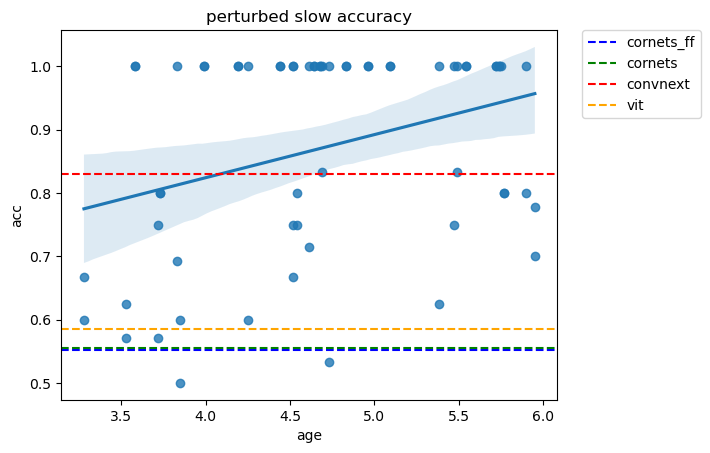

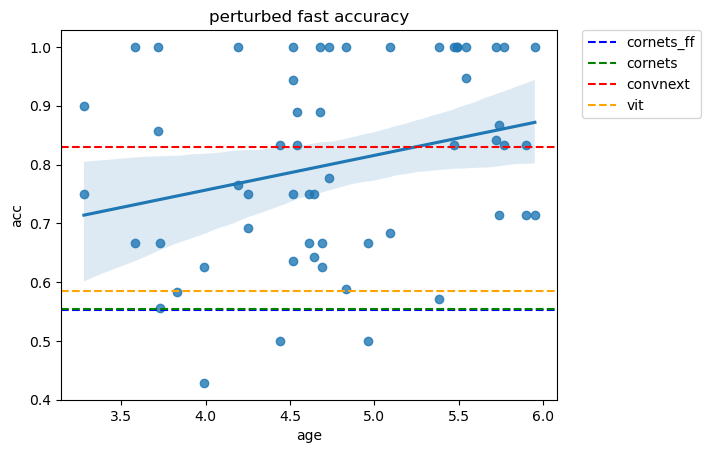

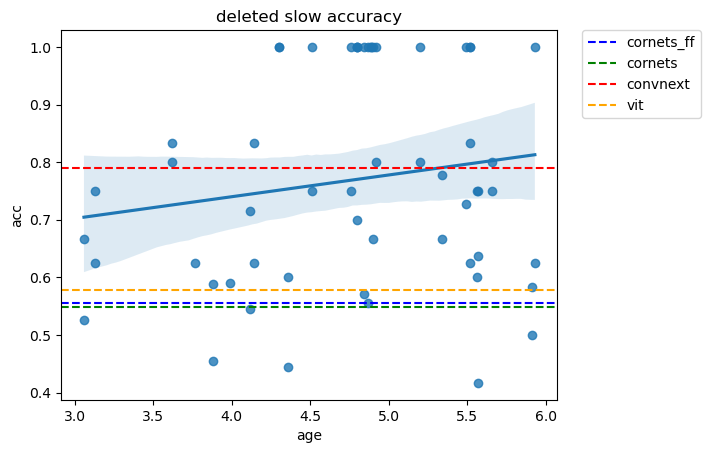

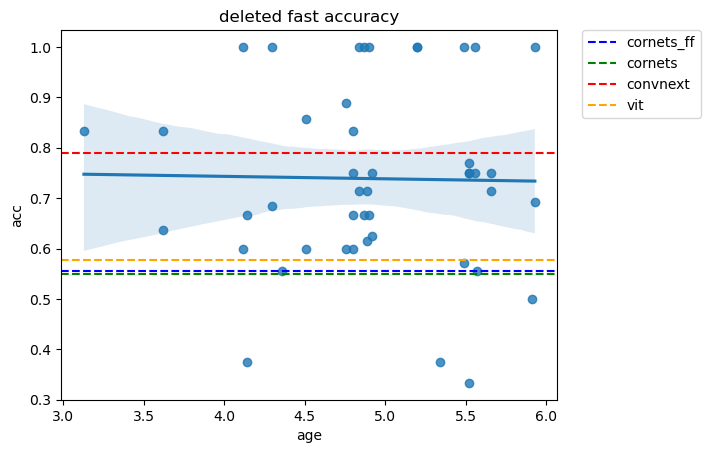

In [63]:
speeds = ['slow','fast']
conds = ['complete','perturbed','deleted']
model_conds = ['Outline','Pert','IC']
sub_summary['age'] = sub_summary['age'].astype(float)
sub_summary['acc'] = sub_summary['acc'].astype(float)

colors = ['b','g','r','orange']



#plot accuracy as a function of speed and condition
for cond in conds:
    for speed in speeds:
        plt.figure()
        #sns.scatterplot(x = 'age', y = 'acc', data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['speed']==speed)])
        ax = sns.regplot(x = 'age', y = 'acc', data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['speed']==speed)])
        plt.title(f'{cond} {speed} accuracy')
        #plt.savefig(f'{results_dir}/{cond}_{speed}_acc.png')
        n = 0
        #load model data in seperate colors as Y-intercept
        for model in models:
            model_data = pd.read_csv(f'{results_dir}/{model}_{model_conds[conds.index(cond)]}_summary.csv')
            model_acc = model_data['acc'].mean()

            #plote model data as a horizontal line
            plt.axhline(y = model_acc, color = colors[n], linestyle = '--',label = model)

            
            n+=1

        handles, _ = ax.get_legend_handles_labels()
        plt.legend(handles = handles[0:],labels = models,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        #place legend outside of graph
        plt.savefig(f'{fig_dir}/{cond}_{speed}_acc.png', bbox_inches='tight')
        plt.show()
        

In [25]:
rt

,resp.corr,resp.rt,pracTrials.thisRepN,pracTrials.thisTrialN,pracTrials.thisN,pracTrials.thisIndex,pracTrials.ran,participant,frameRate,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,trials.ran,objNum
Duration,,,,,,,,,,,,,,,
0.10,1.0,7.779913,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,22.666667,22.666667,11.916667,1.0,19.416667
0.15,1.0,6.317155,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,11.500000,11.500000,14.833333,1.0,24.833333
0.20,1.0,3.647547,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,6.000000,6.000000,18.000000,1.0,28.666667
0.25,1.0,6.800162,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,3.000000,3.000000,12.333333,1.0,19.333333
0.30,1.0,3.573078,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,0.500000,0.500000,13.500000,1.0,23.000000
